# Recap

Previously:

* Text sources (Wikipedia, web crawls, ...)
* Basic text processing tasks (tokenization, part-of-speech tagging, ...)
* Off-the-shelf tools for performing these tasks

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/english_parsing_example.png" width="90%" align="left">

<hr>

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/finnish_parsing_example2.png" width="90%" align="left">

This time:

# Named Entity Recognition

* Recognize mentions of *named entities* (people, places, companies, etc.) and their types (`PER[SON]`, `LOC[ATION]`, etc.) in text
    * Commonly expanded to include also mentions of e.g. dates
    * In specialized domains, recognize names of e.g. genes, proteins, chemicals, ...
* Basic task in information extraction: need to know what things are talked about
* Reliable for well-studied text domains in resource-rich languages (e.g. English news), often over 90% precision and recall
    * Much worse for e.g. Finnish Twitter

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/english_ner_example.png">

<hr>

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/finnish_ner_example.png" width="90%" align="left">

### Approaches

* Dictionary lookup: simple and fast, but no list is complete, no answer to ambiguity (e.g. "Nokia" as `ORG` vs `LOC`, "Bush" as `PER` vs common noun) 
* Rule-based systems: able to take context into account, but require manual tuning, can be brittle
* Machine learning: state-of-the-art results, can be retrained, but require manual annotation (supervised)

# Sequence labeling

* Fundamental machine learning task: assign a class (label) to each item in a sequence
    * Given observed input sequence ***x*** = { *x<sub>1</sub>*, *x<sub>2</sub>*, ... *x<sub>n</sub>* }, predict outputs ***y*** = { *y<sub>1</sub>*, *y<sub>2</sub>*, ... *y<sub>n</sub>* }
* Examples in NLP: part-of-speech tagging, chunking, **named entity recognition**, speech recognition

<hr>
<b>
    
```
x:    The  quick  brown  fox   jumps  over  the  lazy  dog
       ↓     ↓      ↓     ↓     ↓      ↓     ↓    ↓     ↓
y:    DET   ADJ    ADJ   NOUN  VERB   ADP   DET  ADJ   NOUN
```

</b>
<hr>

* Also: time sequences, biological sequences (DNA, amino acid), etc.
* Simply predicting ***x*** ↦ *y<sub>i</sub>* separately for each *y<sub>i</sub>* misses dependencies between outputs 
    * For example, in English, `ADJ` and `DET` are likely before `NOUN` but unlikely after

## NER as sequence labeling

* Given a sequence of words, determine for each whether it is (a part of) a name
* *Begin-In-Out* (BIO) encoding:
    * A token can <b>B</b>egin an entity, be <b>I</b>nside an entity, or be <b>O</b>utside an entity
    * Tags also encode entity type: **B-PER**, **I-PER**, **B-ORG**, **I-ORG**
* NER as multiclass classification: assign each word to one class

<hr>

```
x:    Adams  will  miss  England's   opening  World   Cup  qualifier
        ↓     ↓     ↓       ↓           ↓       ↓      ↓      ↓
y:    B-PER   O     O     B-LOC         O     B-MISC I-MISC   O
```

<hr>

* The same approach can also be used for e.g. chunking (partial parsing)
* Limitation: discontinuous and overlapping spans

# Learning sequence labeling

* Supervised machine learning: requires data for training
    * We assume examples of inputs ***x*** with correct outputs ***y*** (typically manually annotated)
    * Train ML method to predict outputs for new, unseen inputs → Need to *generalize*, not simply memorize (x,y) pairs from training data
* Key question: how to represent the data to the ML method as *features*
    * Examples: words (``Finland``) prefixes/suffixes (`Fin-`, `-and`), POS tags (`NOUN`), word shape (`STARTS-WITH-CAPITAL`), ...


# Sequence classification

* Individual decisions on tokens do not take into account dependencies between classes
* Exactly the sort of "`I-TYPE` must be preceded by `B-TYPE` or `I-TYPE`" (for any `TYPE`) restrictions
    * But also less hard, probabilistic constraints
* Taking into account class dependencies should give a better model


## Naive Bayes

* Simple probabilistic classification method popularized by success in spam filtering
* Predict probability each class <i>y</i> given input <i>x</i> using Bayes' rule $P(y|x) = \frac{P(y)P(x|y)}{P(x)}$, pick most likely 
* Estimate probabilities based on (x,y) counts in training data (+smoothing), e.g.
    * Prior: `P(B-PER) = count(*, B-PER) / total-examples`
    * Conditional: `P(Adam|B-PER) = count(Adam, B-PER) / count(*, B-PER)`
* Simple and fast, but limited: assumes independence of features (the "naive" part -- almost always false!) and predictions (no notion of sequence)

## Hidden Markov Models (HMM)

* "Sequence version" of Naive Bayes: in addition to output probabilities, model also *transition probabilities* $P(y_i|y_{i-1})$
    * Markov assumption: probability of state depends only on previous state (not whole history)

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/bayes_hmm.png" width="50%">

<div style="text-align:center; color:gray; font-size:80%">(Figure modified from <a href="https://arxiv.org/pdf/1011.4088v1.pdf">Sutton and McCallum (2011)</a>)

* Assume an underlying "hidden" sequence of class labels, which generates the observed data

<hr>
<b>
    
```
y:    DET →  ADJ  →  ADJ →  NOUN → VERB → ADP → DET → ADJ → NOUN
       ↓      ↓       ↓      ↓      ↓      ↓     ↓     ↓     ↓
x:    The   quick   brown   fox   jumps   over  the  lazy   dog
```

</b>
<hr>

* Transition probabilities can also be straightforwardly estimated from data, e.g.
    * `P(I-PER|B-PER) = count-seq(I-PER, B-PER) / count-seq(*, B-PER)`
* Decoding: Viterbi algorithm - efficient polynomial algorithm to find the best hidden sequence of labels for the observed data
* Incorporates sequence information, but otherwise retains the independence assumptions from Naive Bayes


## Conditional Random Fields (CRF)

(Specifically, linear-chain CRFs)

* *Discriminative* sequence classifier: estimate conditional probability $P(\textbf{y}|\textbf{x})$ (this is what we're interested in)
    * We know the observed data (and don't care about it's probability) and want to predict the output (i.e. discriminate between possible outputs)
    * (By contrast, *generative* models such as NB and HMM estimate the joint distribution $P(\textbf{x},\textbf{y})$)

<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/sutton_mccallum_models.png" width="80%">

<div style="text-align:center; color:gray; font-size:80%">(Figure modified from <a href="https://arxiv.org/pdf/1011.4088v1.pdf">Sutton and McCallum (2011)</a>)

* Avoid the independence assumptions made by HMMs (HMM is a special case of CRF)
* The go-to ML method for many sequence classification tasks since its introduction in 2001 ([paper](https://people.cs.umass.edu/~mccallum/papers/crf-icml01.ps))
    * (Many recent methods combine feature learning with CRF loss functions)
* Trained iteratively using gradient descent; can get stuck in a local optimum and can be slow
* Decoded in much the same way as HMMs - efficient polynomial algorithm to find the best sequence of labels

We won't go into any real details here, you can check out one of the many tutorials out there if you want to know more about the inner workings of CRFs and the way they're trained (e.g. [this one](http://www.cs.upc.edu/~aquattoni/AllMyPapers/crf_tutorial_talk.pdf)). For a comprehensive introduction, look <a href="https://arxiv.org/pdf/1011.4088v1.pdf">here</a>.

* From a practical point of view:
    * [CRFsuite](http://www.chokkan.org/software/crfsuite/) is a good general CRF training software
    * [NERSuite](http://nersuite.nlplab.org/) a driver script for *CRFsuite* with predefined features tuned for the NER task
    * [CoreNLP](https://stanfordnlp.github.io/CoreNLP/) also has a NER annotator (remember we played with it on the first lectures)

# Evaluation

TODO: mention train/dev/test, prec/rec/f, etc.

<hr>

#  Training data for NER

* Supervised machine learning methods require annotated data for training
* Lots of publicly available datasets for various languages and domains out there

Below, we use data from https://github.com/mpsilfve/finer-data ([raw data](https://raw.githubusercontent.com/mpsilfve/finer-data/master/data/digitoday.2014.train.csv))

```
Halvemman	O	O
hintaluokan	O	O
älypuhelimista	O	O
Nokia	B-PRO	B-ORG
Lumia	I-PRO	O
520	I-PRO	O
on	O	O
menestynyt	O	O
hyvin	O	O
,	O	O
Ihamuotila	B-PER	O
vahvisti	O	O
.	O	O
```

We'll use a version parsed using [Turku neural parser](https://turkunlp.org/Turku-neural-parser-pipeline) ([online demo](http://bionlp-www.utu.fi/parser_demo/))

In [45]:
%reload_ext autoreload
%autoreload 2
%run lib/conllu.ipynb


#train_sentences = read_conll('data/finer-featurized/digitoday.2014.train.conllu')
#devel_sentences = read_conll('data/finer-featurized/digitoday.2014.dev.conllu')
#test_sentences = read_conll('data/finer-featurized/digitoday.2015.test.conllu')
EXAMPLE_IDX = 186    # index of example sentence in training data

train_sentences = read_conll('data/conll03-featurized/eng.train.conllu')
devel_sentences = read_conll('data/conll03-featurized/eng.dev.conllu')
test_sentences = read_conll('data/conll03-featurized/eng.test.conllu')
EXAMPLE_IDX = 219    # index of example sentence in training data


example_sentence = train_sentences[EXAMPLE_IDX]

print('\n'.join('\t'.join(w) for w in example_sentence))

O	-	-	PUNCT	NFP	_	7	punct	_	_
I-LOC	Iraq	Iraq	PROPN	NNP	Number=Sing	4	nmod:poss	_	_
O	's	's	PART	POS	_	2	case	_	_
O	President	president	NOUN	NN	Number=Sing	7	nsubj	_	_
I-PER	Saddam	Saddam	PROPN	NNP	Number=Sing	4	appos	_	_
I-PER	Hussein	Hussein	PROPN	NNP	Number=Sing	5	flat	_	_
O	meets	meet	VERB	VBZ	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	0	root	_	_
O	with	with	ADP	IN	_	9	case	_	_
O	chairman	chairman	NOUN	NN	Number=Sing	7	obl	_	_
O	of	of	ADP	IN	_	16	case	_	_
O	the	the	DET	DT	Definite=Def|PronType=Art	16	det	_	_
I-MISC	Russian	russian	ADJ	JJ	Degree=Pos	15	amod	_	_
O	liberal	liberal	PROPN	NNP	Number=Sing	15	compound	_	_
O	democratic	democratic	PROPN	NNP	Number=Sing	15	compound	_	_
O	party	party	PROPN	NNP	Number=Sing	16	compound	_	_
I-PER	Vladimir	Vladimir	PROPN	NNP	Number=Sing	9	nmod	_	_
I-PER	Zhirinovsky	Zhirinovsky	PROPN	NNP	Number=Sing	16	flat	_	_
O	.	.	PUNCT	.	_	7	punct	_	_


## Data format

The data is in CoNLL-U format (https://universaldependencies.org/format.html), where the TAB-separated fields are defined as

```
    ID: Word index.
    FORM: Word form or punctuation symbol.
    LEMMA: Lemma or stem of word form.
    UPOS: Universal part-of-speech tag.
    XPOS: Language-specific part-of-speech tag.
    FEATS: List of morphological features.
    HEAD: Head of the current word.
    DEPREL: Universal dependency relation to the HEAD.
    DEPS: Enhanced dependency graph.
    MISC: Any other annotation.
```

(The `ID` field is used for the tag.)

We'll mostly be focusing on the first six fields or so.

In [46]:
%run lib/visualization.ipynb

conllu_cols = ["TAG", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]

show_table(example_sentence, columns=conllu_cols)

TAG,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC
O,-,-,PUNCT,NFP,_,7,punct,_,_
I-LOC,Iraq,Iraq,PROPN,NNP,Number=Sing,4,nmod:poss,_,_
O,'s,'s,PART,POS,_,2,case,_,_
O,President,president,NOUN,NN,Number=Sing,7,nsubj,_,_
I-PER,Saddam,Saddam,PROPN,NNP,Number=Sing,4,appos,_,_
I-PER,Hussein,Hussein,PROPN,NNP,Number=Sing,5,flat,_,_
O,meets,meet,VERB,VBZ,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin,0,root,_,_
O,with,with,ADP,IN,_,9,case,_,_
O,chairman,chairman,NOUN,NN,Number=Sing,7,obl,_,_
O,of,of,ADP,IN,_,16,case,_,_


<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/ner_parse_example.png">
<hr>
<img src="https://raw.githubusercontent.com/TurkuNLP/Text_Mining_Course/master/figs/english_parsing_example2.png">

Let's simplify that a bit:

In [55]:
cols = slice(0,4)
print('\n'.join('\t'.join(w[cols]) for w in example_sentence))
show_table([w[cols] for w in example_sentence], columns=conllu_cols[cols])

O	-	-	PUNCT
I-LOC	Iraq	Iraq	PROPN
O	's	's	PART
O	President	president	NOUN
I-PER	Saddam	Saddam	PROPN
I-PER	Hussein	Hussein	PROPN
O	meets	meet	VERB
O	with	with	ADP
O	chairman	chairman	NOUN
O	of	of	ADP
O	the	the	DET
I-MISC	Russian	russian	ADJ
O	liberal	liberal	PROPN
O	democratic	democratic	PROPN
O	party	party	PROPN
I-PER	Vladimir	Vladimir	PROPN
I-PER	Zhirinovsky	Zhirinovsky	PROPN
O	.	.	PUNCT


TAG,FORM,LEMMA,UPOS
O,-,-,PUNCT
I-LOC,Iraq,Iraq,PROPN
O,'s,'s,PART
O,President,president,NOUN
I-PER,Saddam,Saddam,PROPN
I-PER,Hussein,Hussein,PROPN
O,meets,meet,VERB
O,with,with,ADP
O,chairman,chairman,NOUN
O,of,of,ADP


## Statistics

Overall statistics of the annotation:

In [56]:
def conll_stats(sentences, tag_idx=0):
    sent_count = len(sentences)
    word_count = sum(len(s) for s in sentences)
    tag_count = len(set(w[tag_idx] for s in sentences for w in s))
    return sent_count, word_count, tag_count

for label, sentences in (("Training", train_sentences),
                         ("Development", devel_sentences),
                         ("Test", test_sentences)):
    print("{:12s}: {} sentences,\t{} words,\t{} unique tags".format(label, *conll_stats(sentences)))

Training    : 14987 sentences,	204567 words,	8 unique tags
Development : 3466 sentences,	51578 words,	6 unique tags
Test        : 3684 sentences,	46666 words,	8 unique tags


Tag distribution:

170524	O
11128	I-PER
10001	I-ORG
8286	I-LOC
4556	I-MISC
37	B-MISC
24	B-ORG
11	B-LOC


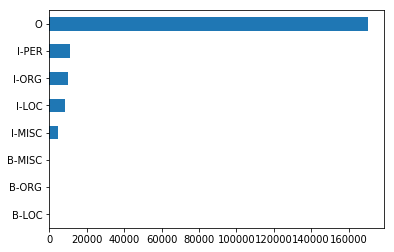

In [57]:
%matplotlib inline

from collections import Counter


def count_tags(sentences, tag_idx=0):
    counter = Counter(w[tag_idx] for s in sentences for w in s)
    for tag in sorted(counter, key=counter.get):
        yield tag, counter[tag]


tag_count = list(count_tags(train_sentences))

for tag, count in reversed(tag_count):
    print('{}\t{}'.format(count, tag))

plot_barh([c for t, c in tag_count], index=[t for t, c in tag_count]);    # ; is intended

Almost all words are tagged `O`, i.e. not part of a named entity. Let's see the rest in more detail:

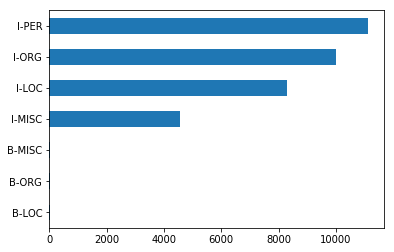

In [58]:
plot_barh([c for t, c in tag_count[:-1]], index=[t for t, c in tag_count[:-1]]);

The tag distribution is characteristic of NER datasets: the great majority of words are not part of any name, and the distribution of types is skewed.

(We'll be coming back to this.)

# Feature generation

We'll be looking at features derived from the following parts of the data:

```
[
 'B-ORG',                 # 0: tag
 'Nokian',                # 1: word form
 'Nokia',                 # 2: lemma
 'PROPN',                 # 3: universal part of speech tag
 'N',                     # 4: language-specific part of speech tag
 'Case=Gen|Number=Sing',  # 5: morphological features
 '2',                     #
 'nmod:poss,              # (... we will ignore the stuff here)
 '_',                     #
 '_'                      #
]
```

Separate the tags from the rest of the data, drop stuff we don't care so much about, and name the rest so that we can say things like `word.lemma` instead of `word[2]`.

In [59]:
from collections import namedtuple
from pprint import pprint as pretty_print


Word = namedtuple('Word', [
    'form',
    'lemma',
    'upos',
    'xpos',
    'morpho',
])


def reformat_sentences(sentences):
    # separate tags, drop parse fields, cast as namedtuples
    tags, data = [], []
    for sentence in sentences:
        tags.append([w[0] for w in sentence])
        data.append([Word(*w[1:6]) for w in sentence])
    return tags, data


train_y, train_data = reformat_sentences(train_sentences)
devel_y, devel_data = reformat_sentences(devel_sentences)
test_y, test_data = reformat_sentences(test_sentences)

pretty_print(train_data[EXAMPLE_IDX])
pretty_print(train_y[EXAMPLE_IDX])

[Word(form='-', lemma='-', upos='PUNCT', xpos='NFP', morpho='_'),
 Word(form='Iraq', lemma='Iraq', upos='PROPN', xpos='NNP', morpho='Number=Sing'),
 Word(form="'s", lemma="'s", upos='PART', xpos='POS', morpho='_'),
 Word(form='President', lemma='president', upos='NOUN', xpos='NN', morpho='Number=Sing'),
 Word(form='Saddam', lemma='Saddam', upos='PROPN', xpos='NNP', morpho='Number=Sing'),
 Word(form='Hussein', lemma='Hussein', upos='PROPN', xpos='NNP', morpho='Number=Sing'),
 Word(form='meets', lemma='meet', upos='VERB', xpos='VBZ', morpho='Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin'),
 Word(form='with', lemma='with', upos='ADP', xpos='IN', morpho='_'),
 Word(form='chairman', lemma='chairman', upos='NOUN', xpos='NN', morpho='Number=Sing'),
 Word(form='of', lemma='of', upos='ADP', xpos='IN', morpho='_'),
 Word(form='the', lemma='the', upos='DET', xpos='DT', morpho='Definite=Def|PronType=Art'),
 Word(form='Russian', lemma='russian', upos='ADJ', xpos='JJ', morpho='Degree=Pos'),


## Define features

We will use good old fashioned *explicit* feature representation, manually specifying how each feature is derived from the input data.

(For feature learning, see deep learning courses)

In [60]:
def minimal_featurizer(sentence, idx):
    # Return features for word in index idx in given sentence
    word = sentence[idx]
    features = {
        'form': word.form,
        'upos': word.upos,
    }
    return features


def featurize_sentence(sentence, featurizer=minimal_featurizer):
    return [featurizer(sentence, i) for i in range(len(sentence))]


train_x = [featurize_sentence(s) for s in train_data]
devel_x = [featurize_sentence(s) for s in devel_data]
test_x = [featurize_sentence(s) for s in test_data]

pretty_print(train_x[EXAMPLE_IDX])
pretty_print(train_y[EXAMPLE_IDX])

[{'form': '-', 'upos': 'PUNCT'},
 {'form': 'Iraq', 'upos': 'PROPN'},
 {'form': "'s", 'upos': 'PART'},
 {'form': 'President', 'upos': 'NOUN'},
 {'form': 'Saddam', 'upos': 'PROPN'},
 {'form': 'Hussein', 'upos': 'PROPN'},
 {'form': 'meets', 'upos': 'VERB'},
 {'form': 'with', 'upos': 'ADP'},
 {'form': 'chairman', 'upos': 'NOUN'},
 {'form': 'of', 'upos': 'ADP'},
 {'form': 'the', 'upos': 'DET'},
 {'form': 'Russian', 'upos': 'ADJ'},
 {'form': 'liberal', 'upos': 'PROPN'},
 {'form': 'democratic', 'upos': 'PROPN'},
 {'form': 'party', 'upos': 'PROPN'},
 {'form': 'Vladimir', 'upos': 'PROPN'},
 {'form': 'Zhirinovsky', 'upos': 'PROPN'},
 {'form': '.', 'upos': 'PUNCT'}]
['O',
 'I-LOC',
 'O',
 'O',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-MISC',
 'O',
 'O',
 'O',
 'I-PER',
 'I-PER',
 'O']


### Sidenote

We give features and tags interpretable names such as `form`, `upos`, and `B-PER` for our convenience only. As far as the machine learning method is concerned, these could be anything, e.g. `f1`, `f2`, and `t1`.

(In particular, there is no magic in pairings such as `B-PER` and `I-PER` -- these are opaque to the ML method.)

# CRF training and prediction

We use the [scikit-learn](https://scikit-learn.org/) version of [CRFSuite](http://www.chokkan.org/software/crfsuite/), a fast implementation of CRFs.

In [61]:
import sklearn_crfsuite


crf = sklearn_crfsuite.CRF(all_possible_transitions=True)

We next train (i.e. fit) the CRF on the data. (This takes some time and memory -- don't all run this at once!)

In [62]:
%%time
crf.fit(train_x, train_y)

CPU times: user 34 s, sys: 284 ms, total: 34.3 s
Wall time: 34.6 s


CRF(algorithm=None, all_possible_states=None, all_possible_transitions=True,
  averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
  calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [63]:
%%time
pred_y = crf.predict(devel_x)

CPU times: user 172 ms, sys: 16.7 ms, total: 189 ms
Wall time: 203 ms


(Prediction is *much* faster than training.)

# Evaluation

In [64]:
from sklearn_crfsuite.metrics import flat_accuracy_score as accuracy


print('Accuracy:\t{:.2%}'.format(accuracy(devel_y, pred_y)))

Accuracy:	95.09%


Tagging accuracy over 90%! Is that a great result?

In [65]:
from itertools import islice


word_seq = [w.form for s in devel_data for w in s]
gold_seq = [y for s in devel_y for y in s]
pred_seq = [y for s in pred_y for y in s]

for word, gold, pred in islice(zip(word_seq, gold_seq, pred_seq), 500, 530):
    print('{:20s}\t{}\t{}\t{}'.format(word, gold, pred, pred==gold))

259                 	O	O	True
and                 	O	O	True
207                 	O	O	True
(                   	O	O	True
A.                  	I-PER	I-PER	True
Dale                	I-PER	I-PER	True
69                  	O	O	True
,                   	O	O	True
H.                  	I-PER	I-PER	True
Morris              	I-PER	I-PER	True
69                  	O	O	True
;                   	O	O	True
D.                  	I-PER	I-PER	True
Blenkiron           	I-PER	I-PER	True
4-43                	O	O	True
)                   	O	O	True
,                   	O	O	True
Durham              	I-ORG	I-ORG	True
114                 	O	O	True
(                   	O	O	True
S.                  	I-PER	I-PER	True
Watkin              	I-PER	I-PER	True
4-28                	O	O	True
)                   	O	O	True
and                 	O	O	True
81-3                	O	O	True
.                   	O	O	True
Tunbridge           	I-LOC	I-PER	False
Wells               	I-LOC	I-PER	False
:                   	O	O	True


Remember this?

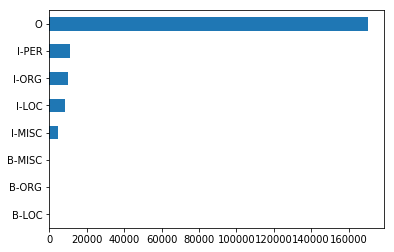

In [66]:
plot_barh([c for t, c in tag_count], index=[t for t, c in tag_count]);

In [67]:
O_count = len([t for t in gold_seq if t == 'O'])
total_count = len(gold_seq)
print("'O' tags: {}/{} ({:.2%})".format(O_count, total_count, O_count/total_count))

'O' tags: 42975/51578 (83.32%)


Due to the frequency of the `O` tag in the data, it's trivial to achieve high accuracy: just always predict `O`.

To get a better picture of what's going on, look at metrics for tags other than `O`. (The "out" class `O` is understood as negative.)

In [68]:
from sklearn_crfsuite.metrics import flat_f1_score as f1_score
from sklearn_crfsuite.metrics import flat_classification_report as classification_report


exclude_O = [t for t in crf.classes_ if t != 'O']

print(classification_report(devel_y, pred_y, labels=exclude_O))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       I-ORG       0.73      0.67      0.70      2092
      I-MISC       0.88      0.59      0.71      1264
       I-PER       0.86      0.86      0.86      3149
       I-LOC       0.89      0.79      0.84      2094
       B-LOC       0.00      0.00      0.00         0
      B-MISC       0.00      0.00      0.00         4
       B-ORG       0.00      0.00      0.00         0

   micro avg       0.84      0.76      0.79      8603
   macro avg       0.48      0.42      0.44      8603
weighted avg       0.84      0.76      0.79      8603



(That's pretty bad.)

### Sidenote

This isn't quite how NER systems are evaluated either: instead of looking at whether individual words are tagged correctly or incorrectly (as we have done here), the most commonly used metrics are based on the recognition of entity mentions.

This means that a correctly tagged multi-word mention such as `Time Warner Cable` counts as one correct name, not three correct tags. (No partial credit is given for e.g. `Time Warner`.)

For datasets with many multi-word mentions, this is a considerably more demanding metric.

(If you're interested, there's a python implementation at https://github.com/spyysalo/conlleval.py)

# Analysis

What did the CRF learn?

In [69]:
import eli5

from eli5.sklearn_crfsuite.explain_weights import sorted_for_ner


eli5.show_weights(crf, targets=sorted_for_ner(crf.classes_), show=['targets'], top=30)

The model is almost exclusively memorizing individual words. While this strategy might work for recognizing the names of months (for `DATE`), it will never scale to recognize people or organizations.

(Then again, we didn't give the model much else to work off ... `upos:` features do appear where relevant.)

Let's look at transitions weights, i.e. what the model learned about the probability of particular tags following other tags.

In [18]:
eli5.show_weights(crf, targets=sorted_for_ner(crf.classes_), show=['transition_features'])

From \ To,O,B-DATE,I-DATE,B-EVENT,I-EVENT,B-LOC,I-LOC,B-ORG,I-ORG,B-PER,I-PER,B-PRO,I-PRO
O,2.665,1.704,-1.844,1.403,-1.304,2.273,-1.219,1.695,-1.781,1.548,-1.582,2.168,-1.571
B-DATE,0.132,-0.558,5.261,0.87,-0.17,0.384,-0.135,-0.256,-0.281,-1.06,-0.22,-0.767,-0.351
I-DATE,-0.039,-1.281,4.345,-0.227,-0.132,-0.146,-0.105,-0.715,-0.231,-0.861,-0.165,-1.07,-0.294
B-EVENT,-0.555,-0.357,-0.093,-0.076,4.991,0.747,-0.053,-1.037,-0.135,-0.923,-0.107,-0.842,-0.128
I-EVENT,-0.871,-0.067,-0.068,-0.073,5.557,0.317,-0.053,-1.3,-0.124,-0.927,-0.106,-0.564,-0.127
B-LOC,0.413,-0.075,-0.623,1.341,-0.504,0.517,3.898,-1.091,-1.031,-2.419,-0.762,-1.255,-0.833
I-LOC,-0.527,0.3,-0.147,1.402,-0.138,0.21,4.058,-1.656,-0.322,-1.297,-0.219,-1.169,-0.245
B-ORG,1.61,0.435,-0.65,-0.398,-0.56,-0.076,-0.565,-1.183,5.288,-0.472,-0.885,0.95,-1.062
I-ORG,0.652,-0.35,-0.389,-0.43,-0.368,-0.766,-0.357,-0.706,5.168,-1.447,-0.603,-1.757,-0.641
B-PER,1.216,-0.7,-0.234,-0.256,-0.202,-1.175,-0.225,-1.608,-0.473,-2.097,6.421,-1.643,-0.408


The model has (mostly) learned that

* `B-` tags can follow `O`, but `I-` tags cannot (first row)
* An `O` tag can follow any tag (second row)
* Transitions from a `B-` tag to the corresponding `I-` tag are likely (e.g. `B-PER` -> `I-PER`) (diagonal)
* Transitions from `B-` to `B-` are unlikely. (diagonal)

This holds in the task setting and training data and should generalize to unseen data.

# Improvements

The above minimal featurizer only looked at the word form and part-of-speech tag, but we have more information than that, particularly lemmas and morphological features (e.g. whether a word is plural).

Also, recall that names such as `form:Maaliskuuta` are for humans only; for the machine learning method, this feature could equally well be called `f17465981`. The CRF *cannot know* e.g. that `form:Maaliskuuta` implies that the lowercased word is "maaliskuuta" or that the word has the prefix "Maaliskuu" and cannot infer such features; we have to tell it ourselves.

In [19]:
def less_minimal_featurizer(sentence, idx):
    word = sentence[idx]
    features = {
        'form': word.form,
        'form.lower()': word.form.lower(),
        'form[:2]': word.form[:2],
        'form[:3]': word.form[:3],
        'form[-2:]': word.form[-2:],
        'form[-3:]': word.form[-3:],
        'lemma': word.lemma,
        'lemma.lower()': word.lemma.lower(),
        'upos': word.upos,
        'xpos': word.xpos,
    }
    # morpho is either empty ("_") or like this: "Case=Nom|Number=Sing"
    if word.morpho == '_':
        features['morpho'] = '_'
    else:
        for attr, val in [m.split('=') for m in word.morpho.split('|')]:
            features['morpho.{}'.format(attr)] = val
    return features


train_x = [featurize_sentence(s, less_minimal_featurizer) for s in train_data]
devel_x = [featurize_sentence(s, less_minimal_featurizer) for s in devel_data]
test_x = [featurize_sentence(s, less_minimal_featurizer) for s in test_data]

pretty_print(train_x[EXAMPLE_IDX])

[{'form': 'Halvemman',
  'form.lower()': 'halvemman',
  'form[-2:]': 'an',
  'form[-3:]': 'man',
  'form[:2]': 'Ha',
  'form[:3]': 'Hal',
  'lemma': 'halpa',
  'lemma.lower()': 'halpa',
  'morpho.Case': 'Gen',
  'morpho.Degree': 'Cmp',
  'morpho.Number': 'Sing',
  'upos': 'ADJ',
  'xpos': 'A'},
 {'form': 'hintaluokan',
  'form.lower()': 'hintaluokan',
  'form[-2:]': 'an',
  'form[-3:]': 'kan',
  'form[:2]': 'hi',
  'form[:3]': 'hin',
  'lemma': 'hinta#luokka',
  'lemma.lower()': 'hinta#luokka',
  'morpho.Case': 'Gen',
  'morpho.Number': 'Sing',
  'upos': 'NOUN',
  'xpos': 'N'},
 {'form': 'älypuhelimista',
  'form.lower()': 'älypuhelimista',
  'form[-2:]': 'ta',
  'form[-3:]': 'sta',
  'form[:2]': 'äl',
  'form[:3]': 'äly',
  'lemma': 'äly#puhelin',
  'lemma.lower()': 'äly#puhelin',
  'morpho.Case': 'Ela',
  'morpho.Number': 'Plur',
  'upos': 'NOUN',
  'xpos': 'N'},
 {'form': 'Nokia',
  'form.lower()': 'nokia',
  'form[-2:]': 'ia',
  'form[-3:]': 'kia',
  'form[:2]': 'No',
  'form[:3]':

Re-train and evaluate with the improved feature representation:

In [20]:
%%time
crf = sklearn_crfsuite.CRF(all_possible_transitions=True)
crf.fit(train_x, train_y)
pred_y = crf.predict(devel_x)

CPU times: user 1min 19s, sys: 1.35 s, total: 1min 20s
Wall time: 1min 21s


In [21]:
print(classification_report(devel_y, pred_y, labels=exclude_O))

              precision    recall  f1-score   support

       B-ORG       0.82      0.80      0.81       544
       B-PER       0.88      0.77      0.82       185
       I-PER       0.85      0.90      0.88        94
       B-LOC       0.93      0.90      0.91       268
      B-DATE       0.96      0.88      0.92        51
       B-PRO       0.75      0.58      0.65       173
       I-ORG       0.78      0.69      0.73       185
      I-DATE       0.97      0.82      0.89        34
       I-PRO       0.50      0.67      0.57        82
     B-EVENT       0.00      0.00      0.00         2
     I-EVENT       0.00      0.00      0.00         2
       I-LOC       1.00      0.40      0.57        20

   micro avg       0.82      0.77      0.80      1640
   macro avg       0.70      0.62      0.65      1640
weighted avg       0.83      0.77      0.79      1640



Much better.

In [22]:
eli5.show_weights(crf, targets=sorted_for_ner(crf.classes_), top=30)

From \ To,O,B-DATE,I-DATE,B-EVENT,I-EVENT,B-LOC,I-LOC,B-ORG,I-ORG,B-PER,I-PER,B-PRO,I-PRO
O,1.079,1.39,-2.466,1.128,-1.338,1.841,-1.252,1.367,-1.803,1.102,-1.65,1.796,-1.664
B-DATE,-1.177,-0.733,4.015,0.604,-0.103,-0.048,-0.101,-0.188,-0.151,-0.556,-0.19,-0.828,-0.266
I-DATE,-1.03,-1.51,4.592,-0.063,-0.05,-0.143,-0.048,-0.225,-0.048,-0.206,-0.043,-0.491,-0.111
B-EVENT,-1.709,-0.171,-0.133,-0.049,4.158,0.46,-0.047,-0.645,-0.083,-0.546,-0.047,-0.517,-0.085
I-EVENT,-2.008,-0.114,-0.041,-0.11,4.679,0.149,-0.076,-0.716,-0.063,-0.433,-0.036,-0.383,-0.068
B-LOC,-0.772,-0.058,-0.344,1.036,-0.36,1.12,3.665,-0.58,-1.169,-1.596,-0.324,-0.668,-0.426
I-LOC,-1.512,0.129,-0.253,0.551,-0.211,0.317,3.662,-1.005,-0.303,-0.6,-0.075,-0.585,-0.1
B-ORG,-0.06,0.324,-0.585,-0.249,-0.695,0.127,-0.587,-1.112,5.373,-0.542,-0.735,0.362,-1.507
I-ORG,-0.725,-0.222,-0.269,-0.231,-0.336,-0.255,-0.312,-0.379,5.54,-1.013,-0.38,-1.257,-0.584
B-PER,-0.139,-0.299,-0.146,-0.152,-0.212,-0.667,-0.224,-1.055,-0.454,-2.488,6.343,-1.212,-0.312


## Context features

When making a prediction for a word, the machine learning method only has access to the features defined for that word. The method it doesn't automatically "remember" previous words it has seen or look at words occurring later in the sentence.

However, we are not limited in this way and can directly represent the features of context words for the method:

In [23]:
def word_features(word, prefix=''):
    features = {
        prefix+'form': word.form,
        prefix+'form.lower()': word.form.lower(),
        prefix+'form[:2]': word.form[:2],
        prefix+'form[:3]': word.form[:3],
        prefix+'form[-2:]': word.form[-2:],
        prefix+'form[-3:]': word.form[-3:],
        prefix+'lemma': word.lemma,
        prefix+'lemma.lower()': word.lemma.lower(),
        prefix+'upos': word.upos,
        prefix+'xpos': word.xpos,
    }
    if word.morpho == '_':
        features[prefix+'morpho'] = '_'
    else:
        for attr, val in [m.split('=') for m in word.morpho.split('|')]:
            features[prefix+'morpho.{}'.format(attr)] = val
    return features


def context_featurizer(sentence, idx):
    features = word_features(sentence[idx], '0:')
    if idx > 0:
        features.update(word_features(sentence[idx-1], '-1:'))
    if idx < len(sentence)-1:
        features.update(word_features(sentence[idx+1], '+1:'))
    return features

train_x = [featurize_sentence(s, context_featurizer) for s in train_data]
devel_x = [featurize_sentence(s, context_featurizer) for s in devel_data]
test_x = [featurize_sentence(s, context_featurizer) for s in test_data]

pretty_print(train_x[EXAMPLE_IDX])

[{'+1:form': 'hintaluokan',
  '+1:form.lower()': 'hintaluokan',
  '+1:form[-2:]': 'an',
  '+1:form[-3:]': 'kan',
  '+1:form[:2]': 'hi',
  '+1:form[:3]': 'hin',
  '+1:lemma': 'hinta#luokka',
  '+1:lemma.lower()': 'hinta#luokka',
  '+1:morpho.Case': 'Gen',
  '+1:morpho.Number': 'Sing',
  '+1:upos': 'NOUN',
  '+1:xpos': 'N',
  '0:form': 'Halvemman',
  '0:form.lower()': 'halvemman',
  '0:form[-2:]': 'an',
  '0:form[-3:]': 'man',
  '0:form[:2]': 'Ha',
  '0:form[:3]': 'Hal',
  '0:lemma': 'halpa',
  '0:lemma.lower()': 'halpa',
  '0:morpho.Case': 'Gen',
  '0:morpho.Degree': 'Cmp',
  '0:morpho.Number': 'Sing',
  '0:upos': 'ADJ',
  '0:xpos': 'A'},
 {'+1:form': 'älypuhelimista',
  '+1:form.lower()': 'älypuhelimista',
  '+1:form[-2:]': 'ta',
  '+1:form[-3:]': 'sta',
  '+1:form[:2]': 'äl',
  '+1:form[:3]': 'äly',
  '+1:lemma': 'äly#puhelin',
  '+1:lemma.lower()': 'äly#puhelin',
  '+1:morpho.Case': 'Ela',
  '+1:morpho.Number': 'Plur',
  '+1:upos': 'NOUN',
  '+1:xpos': 'N',
  '-1:form': 'Halvemman',


In [24]:
%%time
crf = sklearn_crfsuite.CRF(all_possible_transitions=True)
crf.fit(train_x, train_y)
pred_y = crf.predict(devel_x)

CPU times: user 4min 2s, sys: 4.99 s, total: 4min 7s
Wall time: 4min 13s


In [25]:
print(classification_report(devel_y, pred_y, labels=exclude_O))

              precision    recall  f1-score   support

       B-ORG       0.86      0.82      0.84       544
       B-PER       0.93      0.84      0.89       185
       I-PER       0.92      0.88      0.90        94
       B-LOC       0.92      0.88      0.90       268
      B-DATE       0.96      0.92      0.94        51
       B-PRO       0.79      0.62      0.69       173
       I-ORG       0.81      0.76      0.78       185
      I-DATE       0.94      0.88      0.91        34
       I-PRO       0.56      0.61      0.58        82
     B-EVENT       0.00      0.00      0.00         2
     I-EVENT       0.00      0.00      0.00         2
       I-LOC       0.75      0.45      0.56        20

   micro avg       0.86      0.80      0.83      1640
   macro avg       0.70      0.64      0.67      1640
weighted avg       0.86      0.80      0.82      1640



In [26]:
eli5.show_weights(crf, targets=sorted_for_ner(crf.classes_), top=30)

From \ To,O,B-DATE,I-DATE,B-EVENT,I-EVENT,B-LOC,I-LOC,B-ORG,I-ORG,B-PER,I-PER,B-PRO,I-PRO
O,2.944,1.637,-2.113,0.831,-1.031,1.431,-1.553,1.283,-1.98,1.318,-1.67,2.009,-2.262
B-DATE,-0.343,-0.86,2.532,0.221,-0.086,-0.101,-0.077,-0.054,-0.073,-0.267,-0.095,-0.514,-0.167
I-DATE,-0.511,-1.039,2.731,-0.055,-0.061,-0.19,-0.043,0.286,-0.079,-0.033,-0.033,-0.343,-0.235
B-EVENT,-0.729,-0.138,-0.111,-0.067,2.373,0.128,-0.106,-0.45,-0.179,-0.195,-0.137,-0.316,-0.25
I-EVENT,-1.272,-0.127,-0.049,-0.132,2.905,-0.029,-0.142,-0.389,-0.206,-0.116,-0.125,-0.213,-0.2
B-LOC,-0.112,-0.143,-0.248,0.445,-0.432,0.814,2.726,0.026,-1.518,-0.464,-0.61,-0.458,-0.485
I-LOC,-0.755,0.018,-0.076,0.259,-0.253,0.029,2.24,-0.485,-0.406,-0.163,-0.18,-0.299,-0.199
B-ORG,-0.031,0.109,-0.307,-0.499,-0.902,0.179,-0.689,-0.312,4.568,0.893,-1.092,0.754,-2.241
I-ORG,-0.785,-0.213,-0.21,-0.262,-0.46,-0.047,-0.482,0.035,4.285,0.017,-0.687,-0.694,-0.82
B-PER,0.061,-0.155,-0.082,-0.131,-0.384,-0.452,-0.401,-0.29,-0.793,-0.959,4.56,-0.7,-0.68


## Let's have a look at the output

* Print sentences with named entities

In [30]:
def get_tagged(words, tags):
    # Get tagged spans from sequences of words and BIO tags
    tagged, current, current_type = [], [], None
    for word, tag in zip(words, tags):
        if tag[0] in 'OB' and current:    # current ends
            tagged.append((' '.join(current), current_type))
            current, current_type = [], None
        if tag[0] == 'B':
            current, current_type = [word], tag[2:]
        elif tag[0] == 'I':
            if not current:    # I without B, but nevermind
                current, current_type = [word], tag[2:]
            else:
                current.append(word)
                # TODO check that type agrees
        else:
            assert tag == 'O', 'unexpected tag {}'.format(tag)
    if current:    # span open at sentence end
        tagged.append((' '.join(current), current_type))
    return tagged


for sentence, predictions in islice(zip(devel_data, pred_y), 100):
    words = [w.form for w in sentence]
    tagged = get_tagged(words, predictions)
    print(' '.join(words))
    print('NEs: '+','.join('<{1}>{0}</{1}>'.format(text, type_) for text, type_ in tagged))
    print('-'*78)

Kairossa on samalla #äänestä parittajaa-viestillä tuhrittu myös Abdul Fattah al-Sisin vaalimainoksia .
NEs: <ORG>Kairossa</ORG>
------------------------------------------------------------------------------
Kenraali al-Sisin johtama sotilasjuntta kaappasi vallan vaaleissa voittaneelta presidentti Muhammed Mursilta ja Muslimiveljeskunnalta , julisti veljeskunnan rikollisjärjestöksi ja tukahdutti mielenosoitukset yli tuhannen ihmisen kuolemaan johtaneella väkivallalla .
NEs: <ORG>kaappasi</ORG>,<ORG>presidentti</ORG>,<ORG>Muslimiveljeskunnalta</ORG>
------------------------------------------------------------------------------
Mursin islamistisen politiikan vastustajat näkevät al-Sisin pelastajana ja Egyptin tilanteen vakauttajana .
NEs: <ORG>.</ORG>
------------------------------------------------------------------------------
Ihmisoikeusjärjestöt raportoivat sotilashallituksen syyllistyvän laajoihin väärinkäytöksiin .
NEs: <ORG>syyllistyvän</ORG>
---------------------------------------

What are the most common names?

In [28]:
tagged_count = Counter()
for sentence, predictions in zip(devel_data, pred_y):
    words = [w.form for w in sentence]
    for text, type_ in get_tagged(words, predictions):
        tagged_count[(text, type_)] += 1

for (text, type_), count in tagged_count.most_common(50):
	print('{}\t{} ({})'.format(count, text, type_))

25	Facebook (ORG)
23	Google (ORG)
22	Googlen (ORG)
19	Yhdysvallat (LOC)
17	Yhdysvaltain (LOC)
14	Zuckerberg (PER)
13	Turkin (LOC)
12	Facebookin (ORG)
11	Kiinan (LOC)
10	Twitterin (PRO)
10	Applen (ORG)
10	Comcastin (ORG)
10	Pohjois-Korean (LOC)
9	Turkki (LOC)
9	Turkissa (LOC)
9	NSA:n (ORG)
9	Apple (ORG)
8	Lenovo (ORG)
8	Suomen (LOC)
8	Yahoo (ORG)
8	Twitter (PRO)
8	Samsungin (ORG)
8	FBI (ORG)
7	Mark Zuckerberg (PER)
7	Yhdysvalloissa (LOC)
7	Facebookissa (PRO)
7	Suomessa (LOC)
7	Valkoisen talon (ORG)
6	Yhdysvaltoja (LOC)
6	Kiina (LOC)
6	Dotcom (PER)
6	Facebookin (PRO)
6	Venäjällä (LOC)
6	OP:n (ORG)
6	Pohjois-Koreassa (LOC)
5	NSA (ORG)
5	Facebookista (PRO)
5	Kaliforniassa (LOC)
5	Venäjän (LOC)
5	Kiinassa (LOC)
5	Sonyn (ORG)
5	Sullivan (PER)
5	Pohjois-Koreaa (LOC)
5	Pohjois-Korea (LOC)
4	NSA:ta (ORG)
4	The New York Times (ORG)
4	Karpin (PER)
4	Karppi (PER)
4	F-Securen (ORG)
4	Googlea (ORG)


# Improve the model further

There are many ways that we could still try to further improve the model, for example

* Optimize hyperparameters, most importantly regularization parameters `c1` (L1) and `c2` (L2)
* Dictionaties (aka gazetteers): does the word appear in lists of known names of people, cities, countries, etc.
* Word shape features, e.g. "Turku" → "Aaaaa", "NLP" → "AAA", "123" → "###"
* Adding a bias term

(Exercise)

# Use the trained model to tag text from parsebank

(Exercise)